##### import

In [ ]:
import numpy as np
import os

from matplotlib import pyplot as plt
from astropy.io import fits

from scipy.ndimage import median_filter, maximum_filter, minimum_filter, gaussian_filter1d
from scipy.signal import find_peaks
from scipy.interpolate import make_interp_spline

# from skimage.morphology import disk

from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [3]:
from simple_veloce_reduction import veloce_reduction_tools, veloce_config

##### Continuum Fitting Functions

In [36]:
def normalise_thxe_order(y, nknots=30, plot=False):
    x = np.arange(len(y))
    smoothed = median_filter(minimum_filter(y, 100), size=500)
    x_fit = np.linspace(x.min(), x.max(), nknots)
    y_fit = np.interp(x_fit, x, smoothed)
    y_fit[0] = np.nanmin(y[:100])
    y_fit[-1] = np.nanmin(y[-100:])

    # spline = make_interp_spline(x_fit, y_fit, k=3)
    spline = make_interp_spline(x_fit, y_fit, k=3, bc_type=([(1, 0.0)], [(1, 0.0)]))
    baseline = spline(x)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, c='gray', label='Original', alpha=0.5)
        plt.plot(x, smoothed, ls='--', c='k', label='Smoothed')
        plt.scatter(x_fit, y_fit, s=10, c='k', label='Selected knots')
        plt.plot(x, baseline, c='r', label='B-spline fit')
        plt.xlabel('Pixel')
        plt.ylabel('Flux')
        plt.xlim(0, len(y))
        plt.ylim(0, np.max(smoothed) * 1.05)
        plt.legend()
        plt.title('Normalisation of ThXe Order')
        plt.show()

    return y/baseline

In [ ]:
def normalise_thxe_order_with_spline_continuum_estiate(y, nknots=30, norm_type='continuum', node_distribution='linear', smooth=10, bc_type="clamped", plot=False):
    """
    Normalise using spline fitting with continuum estimation and adaptive knot placement.

    This method uses a combination of local peak detection, continuum estimation, and adaptive knot placement
    to create a blaze correction for ThXe orders.

    Parameters:
    - y: 1D array of flux values for the ThXe order.
    - nknots: Number of knots to use for spline fitting.
    - norm_type: 'minimum' to use local minima, 'continuum' to use continuum estimate.
    - node_distribution: 'linear' for evenly spaced knots, 'chebyshev' for Chebyshev nodes.
    - smooth: Smoothing parameter.
    - bc_type: Boundary condition type for spline fitting.
    - plot: If True, generates plots to visualize the process.

    Returns:
    - baseline: Normalized flux values after spline fitting.
    """
    x = np.arange(len(y))
    
    # Initial knot distribution
    if node_distribution == 'linear':
        x_fit = np.linspace(x.min(), x.max(), nknots)
    elif node_distribution == 'chebyshev':
        cheb_nodes = np.cos((2 * np.arange(1, nknots + 1) - 1) * np.pi / (2 * nknots))
        x_fit = 0.5 * (x.max() - x.min()) * (cheb_nodes + 1) + x.min()
        x_fit = np.sort(x_fit)
    else:
        raise ValueError("Invalid node_distribution. Use 'linear' or 'chebyshev'.")
    intial_knots = x_fit.copy()
    # Local percentile-based peak detection (catches weaker peaks)
    window_size = len(y) // (nknots * 2)  # Adaptive window size

    print(f"Using window size: {window_size}")

    signal_peaks = []
    for i in range(len(y)):
        start = max(0, i - window_size//2)
        end = min(len(y), i + window_size//2 + 1)
        local_window = y[start:end]
        # Find peaks in this window
        peaks, _ = find_peaks(local_window, prominence=(np.median(local_window)-np.min(local_window)))
        # Convert local indices to global indices
        global_peaks = (peaks + start).tolist()
        signal_peaks.extend(global_peaks)
     # Extend signal peaks to the 'floor' level (local minimum to left and right)
    extended_peaks = set(signal_peaks)
    for peak in signal_peaks:
        # Search left
        left = peak
        while left > 0 and y[left-1] < y[left]:
            left -= 1
        # Search right
        right = peak
        while right < len(y)-1 and y[right+1] < y[right]:
            right += 1
        # Add all points from left to right (inclusive)
        extended_peaks.update(range(left+1, right)) # don't use the actual floor points 
    extended_peaks = sorted(extended_peaks)
    print(f"Detected {len(extended_peaks)} peaks using signal method with window size {window_size}")
    
    # all_detected_peaks = np.unique(np.concatenate((percentile_peaks, extended_peaks)))
    all_detected_peaks = np.unique(np.array(extended_peaks))
    print(f"Detected {len(extended_peaks)} peaks using signal method with window size {window_size}")
    print(f"Total detected peaks: {len(all_detected_peaks)}")
    
    # Create a mask for all detected peaks
    peak_mask = np.zeros_like(y, dtype=bool)
    peak_mask[all_detected_peaks] = True

    # Interpolate over detected peaks using neighbors that are not rejected
    y_for_min = y.copy()
    if np.any(peak_mask):
        not_peak = ~peak_mask
        # Use linear interpolation for peak regions
        interp_vals = np.interp(x[peak_mask], x[not_peak], y[not_peak])
        y_for_min[peak_mask] = interp_vals

    # Apply minimum filter (same size as y)
    min_filtered = minimum_filter(median_filter(y_for_min, size=window_size//4), size=window_size//2)
    continuum_estimate = gaussian_filter1d(min_filtered, sigma=smooth)  # Smooth estimate
    
    # Line contamination score: how far above continuum estimate
    line_contamination = y - continuum_estimate
    line_contamination[line_contamination < 0] = 0  # make at least 0
    line_contamination /= np.max(line_contamination)
    # line_contamination = gaussian_filter1d(line_contamination, sigma=smooth)  # Smooth line contamination
    
    # Local variance-based detection (high variance = variable region)
    local_variance = np.zeros_like(y)
    for i in range(len(y)):
        start = max(0, i - window_size//10)
        end = min(len(y), i + window_size//10 + 1)
        local_variance[i] = np.var(y[start:end])
    # Variance penalty: high variance regions are less preferred
    smoothed_variance = gaussian_filter1d(local_variance, sigma=smooth)
    max_variance = np.max(smoothed_variance)
    variance_penalty = smoothed_variance / max_variance if max_variance > 0 else np.zeros_like(smoothed_variance)
    print(f"Max variance: {max_variance:.2f}, Variance penalty range: {np.min(variance_penalty):.2f} - {np.max(variance_penalty):.2f}")
    
    # Combined continuum preference score (lower = better for knot placement)
    continuum_score = line_contamination + variance_penalty
    # continuum_score /= np.max(continuum_score)  # Normalize to [0, 1]
    # Optionally scale continuum_score to have a running window maximum of 1 before further processing
    if True:  # Set to True to enable normalization to 1 in running window
        window_norm = window_size // 2
        running_max = np.array([np.max(continuum_score[max(0, i-window_norm):min(len(continuum_score), i+window_norm+1)]) for i in range(len(continuum_score))])
        running_max[running_max == 0] = 1  # Avoid division by zero
        continuum_score = continuum_score / running_max
        
    # Move knots away from detected peaks and towards better continuum regions
    for i, knot in enumerate(x_fit[1:-1]):  # Skip first and last knots
        if continuum_score[int(knot)] == 0:
            # If the knot is already in a good continuum region, skip it
            continue
        else: 
            # Define search range around the knot
            search_radius = window_size  # Adaptive search radius
            search_range = slice(max(0, int(knot)-search_radius), min(len(y), int(knot)+search_radius+1))
            local_x = x[search_range]
            # local_y = y[search_range]
            local_score = continuum_score[search_range]
            # Mask out regions around all detected peaks in this local area
            mask = np.ones_like(local_score, dtype=bool)
            for p in all_detected_peaks:
                if search_range.start <= p < search_range.stop:
                    local_peak_idx = p - search_range.start
                    # Mask out around peaks
                    mask_start = max(0, local_peak_idx - 1)
                    mask_end = min(len(mask), local_peak_idx + 2)
                    mask[mask_start:mask_end] = False
            if np.any(mask):
                # Find the position with minimum continuum score (best continuum location)
                valid_scores = local_score[mask]
                valid_x = local_x[mask]
                # Choose position(s) with lowest contamination * variance penalty
                min_score = np.min(valid_scores)
                best_indices = np.where(valid_scores == min_score)[0]
                if len(best_indices) == 1:
                    best_idx = best_indices[0]
                else:
                    # If multiple, choose the one closest to the original knot
                    distances = np.abs(valid_x[best_indices] - knot)
                    best_idx = best_indices[np.argmin(distances)]
                x_fit[i] = valid_x[best_idx]
            else:
                print(f"Warning: Could not find good continuum region for knot at {knot:.1f}, moving to nearest non-peak.")
                # Move to nearest non-peak in search range
                non_peak_indices = np.where(mask)[0]
                if len(non_peak_indices) > 0:
                    nearest = local_x[mask][np.argmin(np.abs(local_x[mask] - knot))]
                    x_fit[i] = nearest
                else:
                    # As a last resort, remove the knot at its current position
                    x_fit[i] = np.nan
    x_fit[0] = x.min()  # Ensure first knot is at start
    x_fit[-1] = x.max()  # Ensure last knot is at end
    continuum_score[int(x_fit[0])] = -1e-6  # Set first knot score to negative
    continuum_score[int(x_fit[-1])] = -1e-6  # Set last knot score to negative

    # Remove any knots marked as np.nan
    if np.any(np.isnan(x_fit)):
        print("Removing knots that could not be placed in good continuum regions.")
        x_fit = x_fit[~np.isnan(x_fit)]
    # Remove duplicate knots
    if len(x_fit) != len(np.unique(x_fit)):
        print("Removing duplicate knots after placement.")
        x_fit = np.unique(x_fit)
    
    # Ensure knots are still in order and within bounds
    if np.any(x_fit < x.min()) or np.any(x_fit > x.max()):
        print("Clipping knots to valid range.")
        x_fit = np.clip(x_fit, x.min(), x.max())
    x_fit = np.sort(x_fit)

    # Drop knots that are too close together, keeping the one with lower continuum_score
    if node_distribution == 'chebyshev':
        min_dist = smooth
    else:
        min_dist = max(10, window_size // 4)  # Minimum allowed distance between knots
    keep = np.ones(len(x_fit), dtype=bool)
    i = 0
    while i < len(x_fit) - 1:
        if x_fit[i+1] - x_fit[i] < min_dist:
            print(f"Dropping close knots at {x_fit[i]:.1f} and {x_fit[i+1]:.1f}, distance: {x_fit[i+1] - x_fit[i]:.1f}")
            # Compare continuum_score at both knots
            score_i = continuum_score[int(x_fit[i])]
            score_ip1 = continuum_score[int(x_fit[i+1])]
            # Drop the one with higher score
            if score_i <= score_ip1:
                keep[i+1] = False
            else:
                keep[i] = False
            # After dropping, don't increment i to check new neighbor
            x_fit = x_fit[keep]
            keep = np.ones(len(x_fit), dtype=bool)
            i = 0  # Restart to ensure all pairs checked after removal
        else:
            i += 1
    x_fit = x_fit[keep]
    print(f"Final nknot after moving knots and dropping close pairs: {np.sum(keep)} out of {nknots}")
    
    if norm_type == 'minimum':
        y_fit = [np.min(y[int(max(0,_x-smooth)):int(min(len(x),_x+smooth+1))]) for _x in x_fit]  # Use local minima around knots
    elif norm_type == 'continuum':
        y_fit = continuum_estimate[x_fit.astype(int)]  # Use local continuum estimate for knot
    else:
        raise ValueError("Invalid norm_type. Use 'minimum' or 'continuum'.")
    # Improved boundary conditions using continuum estimate
    boundary_width = window_size // 2
    y_fit[0] = np.median(continuum_estimate[:boundary_width])
    y_fit[-1] = np.median(continuum_estimate[-boundary_width:])
    
    # spline = make_interp_spline(x_fit, y_fit, k=3, bc_type=([(1, 0.0)], [(1, 0.0)]))
    spline = make_interp_spline(x_fit, y_fit, k=3, bc_type=bc_type)
    baseline = spline(x)
    
    if plot:
        plt.close('all')
        plt.figure(figsize=(16, 12))
        
        # Top panel: Peak detection analysis
        plt.subplot(4, 1, 1)
        plt.plot(x, y, 'gray', alpha=0.7, label='Original')
        plt.scatter(extended_peaks, y[extended_peaks], marker='x', c='red', s=15, alpha=0.8, label='Signal peaks', zorder=4)
        plt.plot(x, continuum_estimate, 'blue', alpha=0.8, label='Continuum estimate')
        plt.xlim(x.min(), x.max())
        plt.ylim(0, np.max(y) * 1.05)
        plt.ylabel('Flux')
        plt.xlabel('Pixel')
        plt.legend()
        plt.title('Peak Detection and Continuum Estimation')
        
        # Second panel: Continuum scoring and selected knots
        plt.subplot(4, 1, 2)
        plt.plot(x, line_contamination, 'orange', alpha=0.6, label='Line contamination')
        plt.plot(x, variance_penalty, 'green', alpha=0.6, label='Variance penalty')
        plt.plot(x, continuum_score, 'purple', alpha=0.8, label='Continuum score')
        plt.scatter(x_fit, continuum_score[x_fit.astype(int)], s=30, c='blue', edgecolor='white', linewidth=0.5, label='Knots', zorder=5)
        for guess_knot in intial_knots:
            plt.axvline(guess_knot, color='blue', ls='--', alpha=0.5, lw=0.5)
            plt.axvline(guess_knot-window_size, color='red', ls='--', alpha=0.5, lw=0.5)
            plt.axvline(guess_knot+window_size, color='red', ls='--', alpha=0.5, lw=0.5)
        plt.xlim(x.min(), x.max())
        plt.ylim(-0.05, 1.05)
        plt.ylabel('Normalised Score')
        plt.xlabel('Pixel')
        plt.legend()
        plt.title('Scoring and Knot Placement')
        
        # Third panel: Knot placement and fitting
        plt.subplot(4, 1, 3)
        plt.plot(x, y, 'gray', alpha=0.5, label='Original')
        plt.scatter(x[peak_mask], y[peak_mask], marker='x', c='red', s=1, label='Rejected (emission lines)')
        plt.scatter(x_fit, y_fit, s=30, c='blue', edgecolor='white', linewidth=0.5, label='Knots', zorder=5)
        plt.plot(x, baseline, 'b-', linewidth=2, label='Baseline')
        plt.xlim(x.min(), x.max())
        plt.ylim(0, max(baseline) * 1.2)
        plt.ylabel('Flux')
        plt.xlabel('Pixel')
        plt.legend()
        plt.title('Baseline Fitting')
        
        # Bottom panel: Normalized result
        plt.subplot(4, 1, 4)
        plt.plot(x, y/baseline, 'b-', label='Normalised')
        # plt.plot(x, y/continuum_estimate, 'g-', label='Naive Normalisation')
        plt.axhline(1, color='k', ls='--', alpha=0.5)
        plt.xlim(x.min(), x.max())
        plt.ylim(-0.05, np.max(y/baseline) * 1.05)
        plt.ylabel('Normalised Flux')
        plt.xlabel('Pixel')
        plt.legend()
        plt.title('Final Normalised Spectrum')
        
        plt.tight_layout()
        plt.show()
    
    return y/baseline

In [75]:
def normalise_thxe_order_with_smooth_continuum_estimate(y, window_size=50, smooth=10, percentile_threshold=75, plot=False):
    x = np.arange(len(y))
    
    # Local percentile-based peak detection (catches weaker peaks)
    percentile_peaks = []
    # percentile_threshold = 100*(1/sigma_clip**2)  # Adjust threshold based on sigma_clip
    for i in range(len(y)):
        start = max(0, i - window_size//2)
        end = min(len(y), i + window_size//2 + 1)
        local_window = y[start:end]
        if y[i] > np.percentile(local_window, percentile_threshold):  # Above percentile threshold locally
            percentile_peaks.append(i)
    all_detected_peaks = np.array(percentile_peaks)
    
    # Create continuum preference map
    # Create a mask for all detected peaks
    peak_mask = np.zeros_like(y, dtype=bool)
    peak_mask[all_detected_peaks] = True

    # Interpolate over detected peaks using neighbors that are not rejected
    y_for_min = y.copy()
    if np.any(peak_mask):
        not_peak = ~peak_mask
        # Use linear interpolation for peak regions
        interp_vals = np.interp(x[peak_mask], x[not_peak], y[not_peak])
        y_for_min[peak_mask] = interp_vals

    # Apply filter (same size as y)
    min_filtered = minimum_filter(median_filter(y_for_min, size=window_size//10), size=window_size//4)
    continuum_estimate = gaussian_filter1d(min_filtered, sigma=smooth) # Smooth estimate

    if plot:
        plt.figure(figsize=(12, 12))
        # Diagnostic plot
        plt.subplot(2, 1, 1)
        plt.plot(x, y, color='gray', alpha=0.7, label='Original')
        plt.plot(x, continuum_estimate, color='red', linewidth=2, label='Smooth Continuum Estimate')
        plt.scatter(all_detected_peaks, y[all_detected_peaks], color='orange', s=10, label='Detected Peaks')
        plt.xlabel('Pixel')
        plt.ylabel('Flux')
        plt.title('Continuum Estimate and Peak Detection')
        plt.legend()
        plt.tight_layout()
        # Normalized spectrum
        plt.subplot(2, 1, 2)
        plt.plot(x, y / continuum_estimate, color='blue', label='Normalized Spectrum')
        plt.axhline(1, color='k', ls='--', alpha=0.5)
        plt.xlabel('Pixel')
        plt.ylabel('Normalized Flux')
        plt.title('Normalized Spectrum using Smooth Continuum Estimate')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return y / continuum_estimate

In [ ]:
def fit_blaze_spline(y, nknots=50, plot=False):
    x = np.arange(len(y))
    smoothed = median_filter(maximum_filter(y, 10), size=50)
    x_fit = np.linspace(x.min(), x.max(), nknots)
    y_fit = np.interp(x_fit, x, smoothed)
    y_fit[0] = np.nanmin(y[:50])
    y_fit[-1] = np.nanmin(y[-50:])

    spline = make_interp_spline(x_fit, y_fit, k=3)
    blaze = spline(x)
    
    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, c='gray', label='Original', alpha=0.5)
        plt.plot(x, smoothed, ls='--', c='k', label='Smoothed')
        plt.scatter(x_fit, y_fit, s=10, c='k', label='Selected knots')
        plt.plot(x, blaze, c='r', label='B-spline fit')
        plt.xlabel('Pixel')
        plt.ylabel('Flux')
        plt.xlim(0, len(y))
        plt.ylim(0, np.max(smoothed) * 1.05)
        plt.legend()
        plt.title('Model for Blaze Function')
        plt.show()

    return blaze

##### Load Data

In [21]:
run = "CSV_Run"
# run = "WASP189b"
date = "230828"
# date = "240410"
# arm = 'red'
arm = 'green'
# arm = 'blue'
ccd_nums = {'red': 3, 'green': 2, 'blue': 1}
ccd = f'ccd_{ccd_nums[arm]}'
amplifier_mode = 4
# amplifier_mode = 2
# filename = '26aug20055.fits'
# filename = '26aug20061.fits'
science_targets = ['HD20203-USQ01']
# science_targets = ['WASP189b']

In [22]:
input_dir = f'/home/usqobserver2/VeloceData/{run}/'
# output_dir = '/home/usqobserver2/Joachim_veloce/Extracted_data/ThXe/'
output_dir = f'/home/usqobserver2/Joachim_veloce/Extracted_data/{run}/'

In [23]:
veloce_paths = veloce_config.VelocePaths(input_dir=input_dir, output_dir=output_dir)

In [24]:
# master_filename = f'Master/master_ARC-ThAr_{arm}_{date}.fits'
filename = f'{veloce_paths.master_dir}/master_ARC-ThAr_{arm}_{date}.fits'
# veloce_reduction_tools.save_image_fits(master_filename, data, header)
with fits.open(filename) as hdul:
    data= hdul[0].data
    header = hdul[0].header

In [25]:
traces = veloce_reduction_tools.Traces.load_traces(os.path.join(veloce_paths.trace_dir, f'veloce_{arm}_4amp_sim_calib_trace.pkl'))
extracted_ThXe, extracted_ThXe_imgs = veloce_reduction_tools.extract_orders_with_trace(data, traces)

### Tests:

In [10]:
%matplotlib widget

In [26]:
plt.close('all')

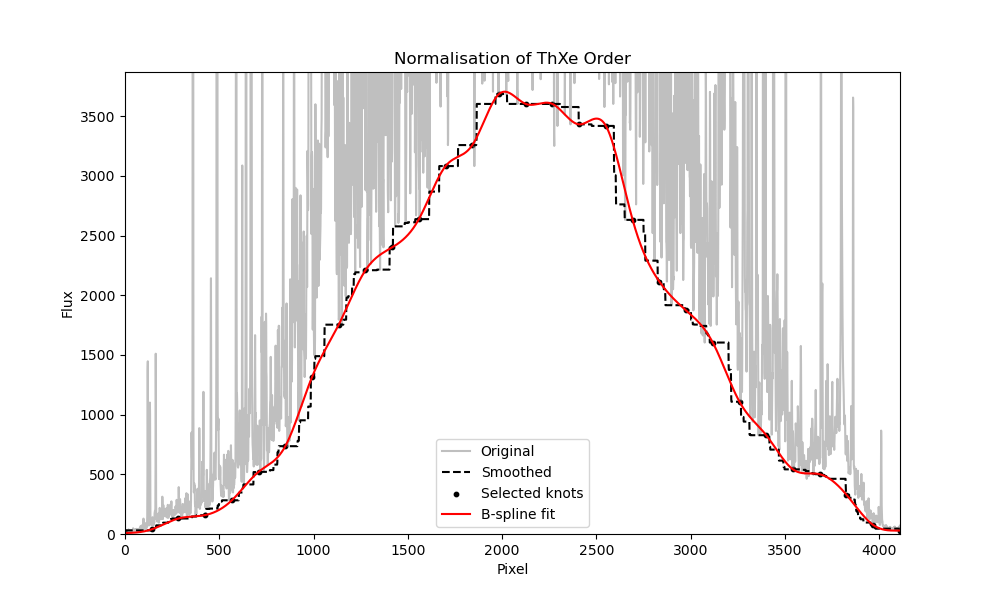

array([2.66666671, 0.99991563, 2.66576039, ..., 1.68984082, 2.24144264,
       2.41379313])

In [37]:
order = 8
normalise_thxe_order(extracted_ThXe[order], nknots=30, plot=True)

Using window size: 158
Detected 2080 peaks using signal method with window size 158
Detected 2080 peaks using signal method with window size 158
Total detected peaks: 2080
Max variance: 128585539433.39, Variance penalty range: 0.00 - 1.00
Final nknot after moving knots and dropping close pairs: 13 out of 13


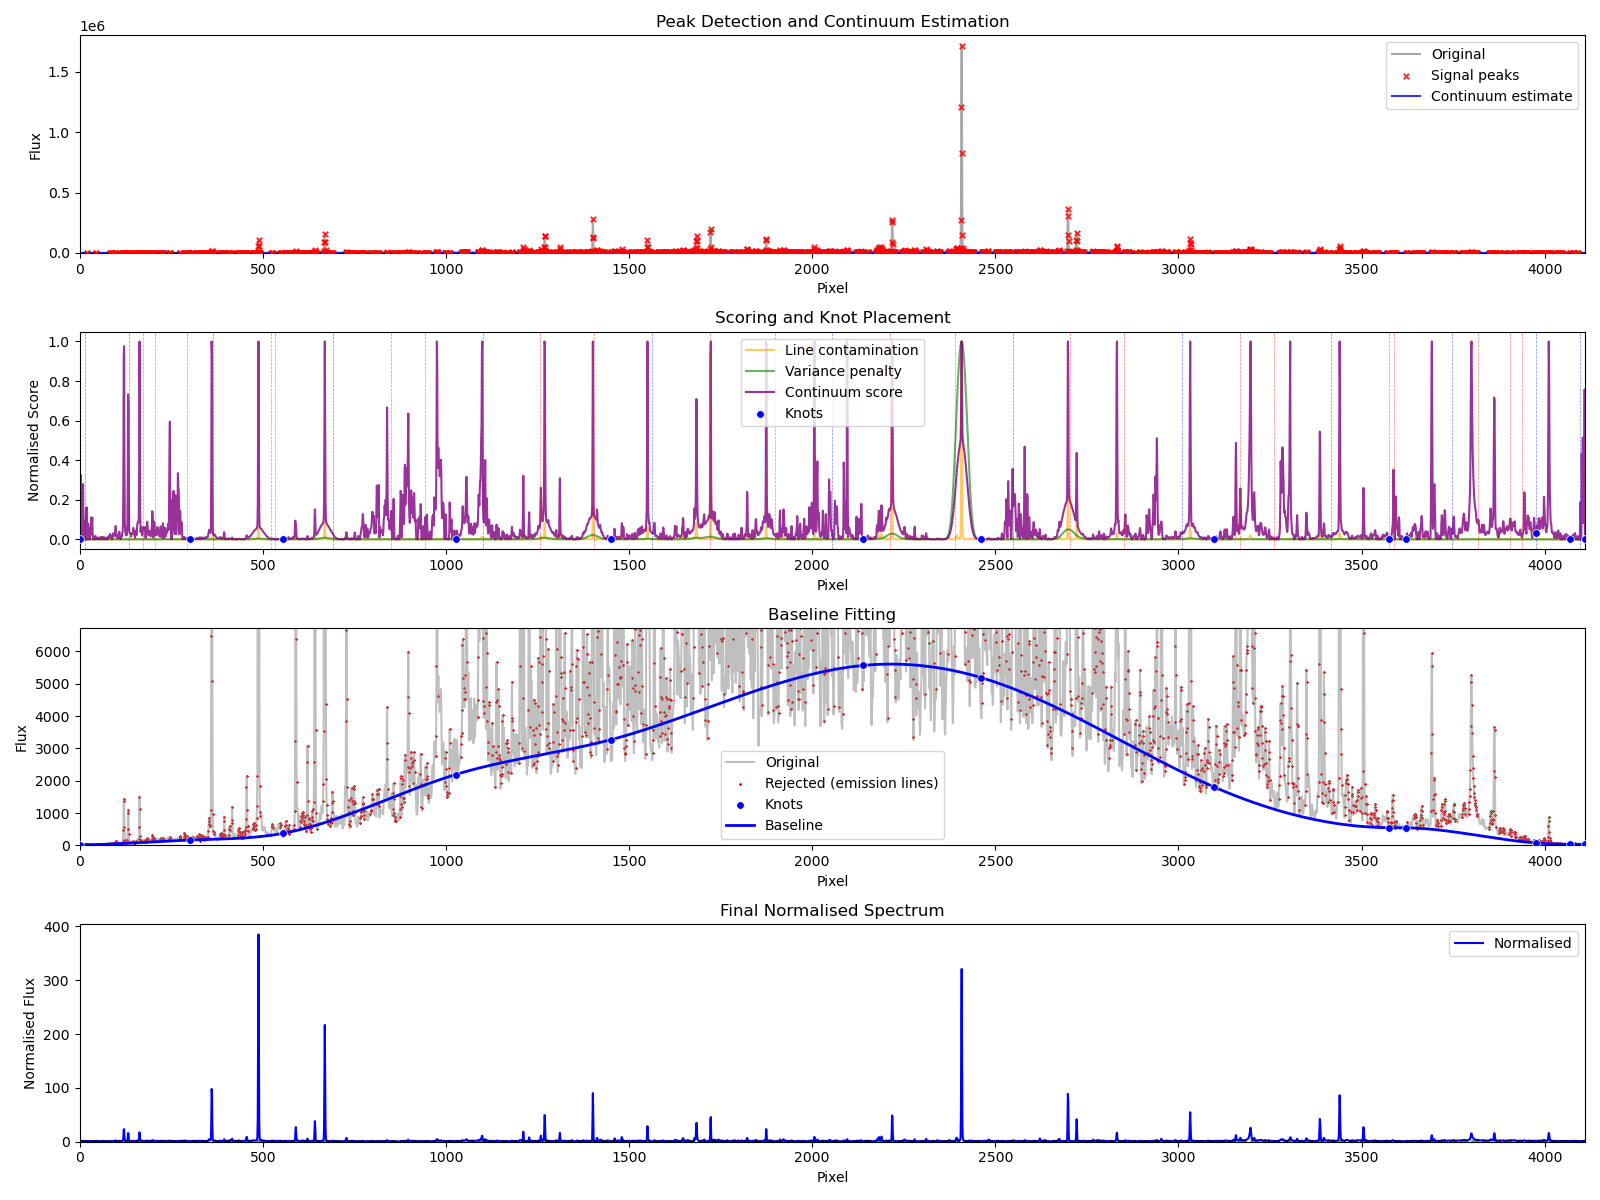

array([0.99114867, 0.37162879, 0.99059571, ..., 1.32451028, 1.75678606,
       1.89184268])

In [34]:
order = 8
normalise_thxe_order_with_spline_continuum_estiate(extracted_ThXe[order], nknots=13, node_distribution='chebyshev', smooth=10, bc_type='clamped', plot=True)

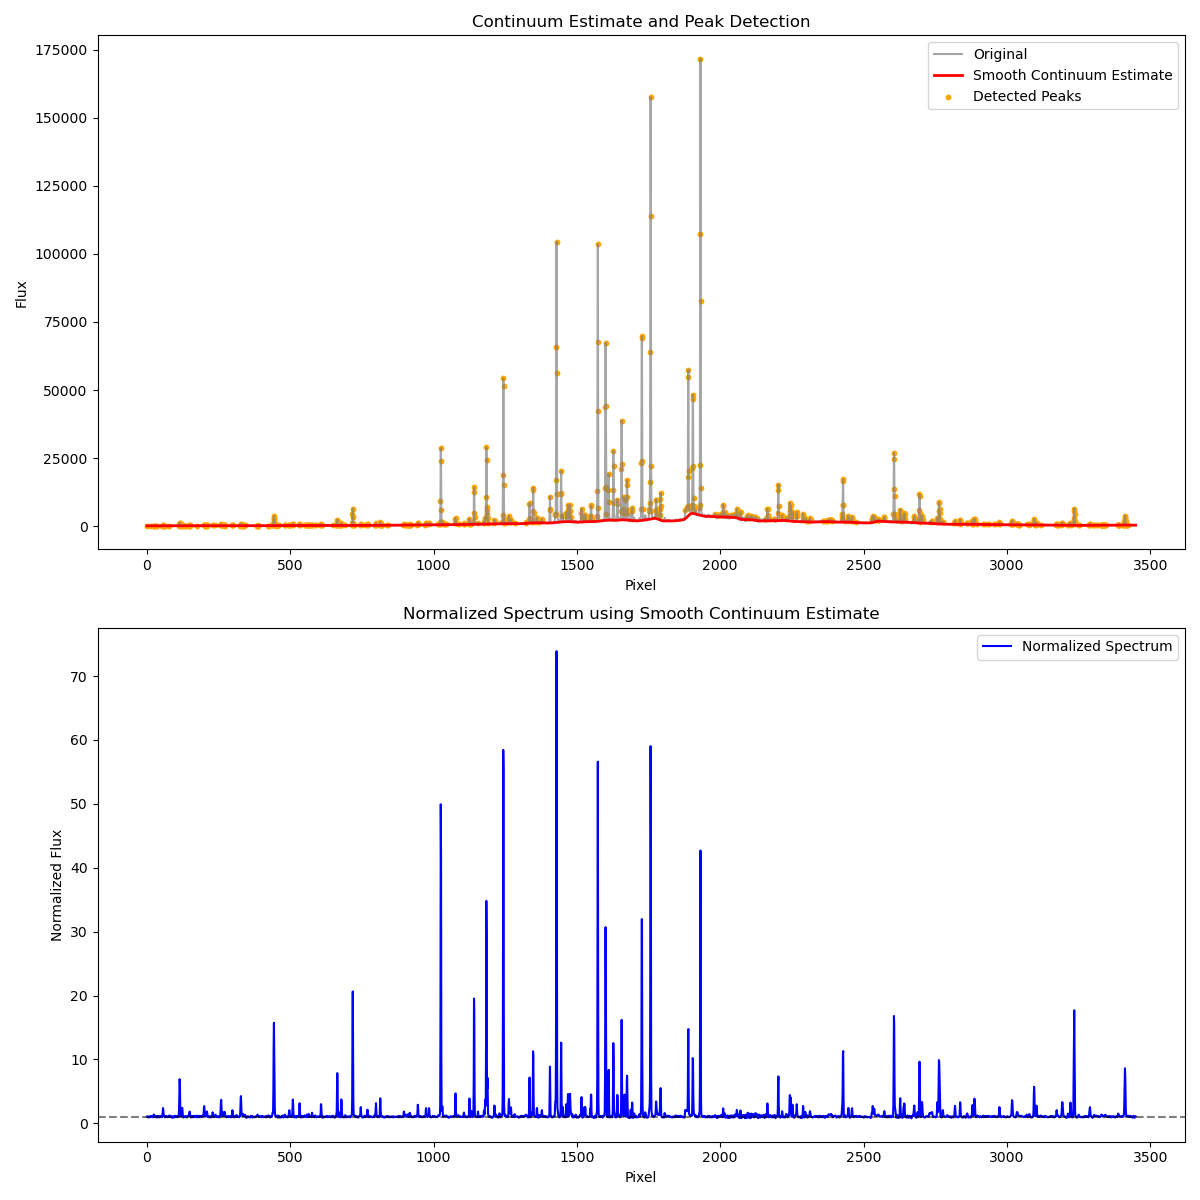

array([0.9993208 , 1.0986394 , 1.0050848 , ..., 0.94492894, 1.0480791 ,
       1.0947794 ], dtype=float32)

In [76]:
normalise_thxe_order_with_smooth_continuum_estimate(extracted_ThXe[order], window_size=100, percentile_threshold=75, plot=True)